# 4. Inferencia y Validación en PyTorch

Aunque entrenar un modelo es muy divertido debido a la naturaleza experimental del proceso, el objetivo real de un modelo es producir prediciones buenas y senstas (es decir, _inferir_). Es este notebook aprenderemos como inferir usando PyTorch.

En ocasiones, una red aprende demasiado bien de sus datos. De hecho, aprende tan bien que pierde su capacidad de generalor y, por lo tanto, lo que realmente hizo fue memorizar. Esta situación se conoce como *__overfitting__*. Un mecanismo para diagnosticar esta circunstancia es usar un conjunto de validación compuesto de imágenes nuevas, con el fin de probar el rendimiento del modelo en data novedosa. Para contrarrestar el _overfitting_ hay varias técnicas de regularización, como _dropout_, la cual también exploraremos en este notebook.

Empecemos importando los paquetes que necesitaremos.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import utils

En la celda de abajo estamos definiendo los iteradores de los conjuntos de entrenamiento y prueba, junto con las transformaciones que aplicaremos a las imágenes en la base de datos Fashion-MNIST.

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_set = datasets.FashionMNIST('Fashion_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('Fashion_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

### Red


Fashion-MNIST, al igual que su contraparte más clásica y sencilla, se componen de imágenes pertenecientes a diez clases diferentes, donde cada fotografía digital tiene 28 pixeles de alto por 28 pixeles de ancho. Cada imagen se encuentra en escala de grises, por lo que sólo tienen un canal (es decir, son una matriz de valores, en vez de un tensor).

En la celda de abajo estamos inicializando la red de una forma que nos permite pasar un número arbitrario de capas ocultas en el parámetro `hidden_layer`. También estamos regularizando usando `dropout`. La proporción de la red que será aleatoriamente apagada es, por defecto, 0.5, aunque este valor se puede cambiar.

Puesto que este es un problema de clasificación multiclase, debemos activar la salida de la red utilizando un softmax logarítmico.

In [3]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_proportion=0.5):
        super().__init__()
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_proportion)
        
    def forward(self, x):
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
            
        x = self.output(x)
        return F.log_softmax(x, dim=1)

### Entrenando la Red

Ya que las salidas de la red han pasado por una función de logaritmo, __NLLLoss (*negative log loss*)__ es el criterio idóneo.

Nuestro optimizador será `Adam` debido a que es una buena opción por defecto que requiere una configuración o puesta a punto mínima.

Un aspecto a tener en cuenta es que _dropout_ debe ser apagado durante la inferencia, porque, de otra manera, dará la impresión de que la red no ha aprendido nada, ya que aproximadamente la mitad de sus neuronas estarán desactivadas. Hemos de recordar que _dropout_ se usa para forzar a la red a usar caminos alternativos para llegar a una misma conclusiíon, reduciendo así la parcialidad o tendencia de ciertas neuronas a activarse en grupo, pero durante la inferencia no estamos entrenando, sino realmente usando la red, por lo que esta medida no es sólo innecesaria, sino contraproducente.

PyTorch nos deja especificar la modalidad de la red: `model.train()` indica que la red está siendo entrenada y, entre otras cosas, permite que dropout esté activado, mientras que `model.eval()` significa que estamos en modo de inferencia o evaluación, por lo que el framework apagará el _dropout_.

In [4]:
model = Network(784, 10, [516, 256], drop_proportion=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
def validation(model, test_loader, criterion):
    test_loss = 0
    accuracy = 0
    
    for images, labels in test_loader:
        images.resize_(images.shape[0], 784)
        
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        
        predictions = torch.exp(output)
        equality = (labels.data == predictions.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

In [6]:
epochs = 5
print_every = 50
steps = 0
running_loss = 0

for epoch in range(1, epochs + 1):
    model.train()  # Set to train mode
    for images, labels in train_loader:
        steps += 1
        
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()  # Sets the network to eval mode
            
            with torch.no_grad():
                test_loss, accuracy = validation(model, test_loader, criterion)
            
            print(f'Epoch: {epoch}/{epochs}...')
            print(f'Training Loss: {running_loss/print_every}')
            print(f'Test Loss: {test_loss/len(test_loader)}')
            print(f'Test Accuracy: {accuracy/len(test_loader)}')
            
            
            running_loss = 0
            model.train()

Epoch: 1/5...
Training Loss: 1.234833129644394
Test Loss: 0.7201380961260219
Test Accuracy: 0.7414410710334778
Epoch: 1/5...
Training Loss: 0.742539918422699
Test Loss: 0.6370721914965636
Test Accuracy: 0.7540804147720337
Epoch: 1/5...
Training Loss: 0.7123897397518157
Test Loss: 0.5877198263718064
Test Accuracy: 0.7772691249847412
Epoch: 1/5...
Training Loss: 0.6325582855939865
Test Loss: 0.5691214015909062
Test Accuracy: 0.7866241931915283
Epoch: 1/5...
Training Loss: 0.6494611334800721
Test Loss: 0.5595568302710345
Test Accuracy: 0.7976711988449097
Epoch: 1/5...
Training Loss: 0.5802896839380264
Test Loss: 0.5389021109243867
Test Accuracy: 0.7994625568389893
Epoch: 1/5...
Training Loss: 0.5760803127288818
Test Loss: 0.5137074728300617
Test Accuracy: 0.8043391704559326
Epoch: 1/5...
Training Loss: 0.5802239853143693
Test Loss: 0.49589177909170745
Test Accuracy: 0.8154856562614441
Epoch: 1/5...
Training Loss: 0.5907466548681259
Test Loss: 0.4919620540681159
Test Accuracy: 0.8185708522

### Inferencia

Con nuestra red entrenada, probémosla con algunas imágenes.

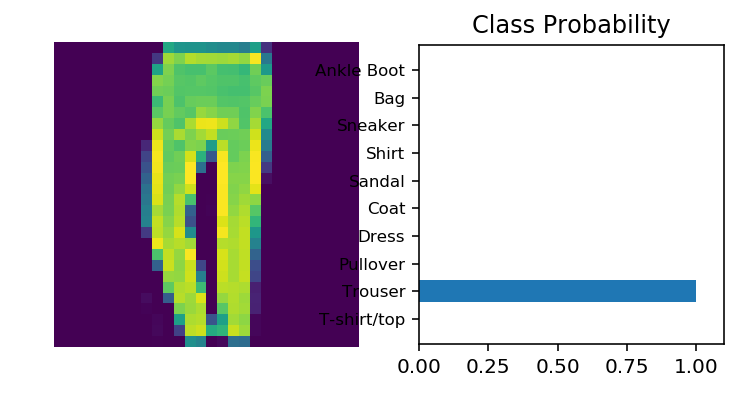

In [7]:
model.eval()

data_iter = iter(test_loader)
images, labels = data_iter.next()
image = images[0]

image = image.view(1, 784)

with torch.no_grad():
    output = model.forward(image)
    
predictions = torch.exp(output)

utils.view_classify(image.view(1, 28, 28), predictions, version='Fashion')